<a href="https://colab.research.google.com/github/hamza74372/Sentiment-Analysis-of-Customer-Reviews/blob/main/Sentiment_Analysis_of_Customer_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
upload = files.upload()

Saving review_updated (4).xlsx to review_updated (4).xlsx


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_excel("review_updated_with_ratings.xlsx")

values = df['dimension'].unique()
print(values)

['169 mm x 117 mm x 9.1 mm' '169.00 mm x 117.00 mm x 9.10 mm'
 '121.92 mm x 167.64 mm x 81.28 mm' '144.80 mm x 38.10 mm x 17.80 mm']


In [ ]:
values2 = df['categories'].unique()
print(values2)
print(len(values2))

['Amazon Devices,mazon.co.uk' 'Kindle Store,Amazon Devices,Electronics'
 'Categories,Amazon Devices,Streaming Media Players' 'Amazon Devices'
 'Categories,Amazon Devices,Electronics Features,Streaming Media Players,Consumer Electronics,See more Amazon Fire TV Digital HD Media Streamer (Late...'
 'Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories'
 'Amazon Devices,Kindle Store' 'Electronics,Amazon Devices'
 'Amazon Devices,Kindle Accessories'
 'Amazon Devices,Electronics,Kindle Store'
 'Amazon Devices,Electronics,Kindle Store,Amazon Echo'
 'Amazon Devices,Kindle Store,Kindle Accessories'
 'Amazon Devices,Kindle Store,buy a kindle'
 'Amazon Devices,Home,Smart Home & Connected Living,Smart Hubs & Wireless Routers,Smart Hubs,Home Improvement,Home Safety & Security,Alarms & Sensors,Home Security,Amazon Echo,Home, Garage & Office,Smart Home,Voice Assistants,Amazon Tap,Electronics Features,TVs 

In [ ]:
import pandas as pd
import random
import re
from datetime import datetime, timedelta

# Step 1: Load the dataset
df = pd.read_excel('review.xlsx')

# Step 2: Convert EANs to strings
df['ean'] = df['ean'].apply(lambda x: str(x) if pd.notna(x) else x)
df['ean'] = df['ean'].fillna('UNKNOWN_EAN')

# Step 3: Check for missing EANs
ean_nulls = df['ean'].isnull().sum()
print(f"Number of missing EANs after replacement: {ean_nulls}")

# Step 4: Convert dimensions from inches to millimeters
def convert_to_mm(dim):
    if isinstance(dim, str) and ' in' in dim:
        nums = [float(x) * 25.4 for x in dim.replace(' in', '').split(' x ')]
        return f"{nums[0]:.2f} mm x {nums[1]:.2f} mm x {nums[2]:.2f} mm"
    return dim

df['dimension'] = df['dimension'].apply(convert_to_mm)
df['reviews.username'] = df['reviews.username'].fillna('unknown')

# Step 5: Define known ASIN mappings
asin_dimensions = {
    'B00QJDU3KY': '169.00 mm x 117.00 mm x 9.10 mm',  # Kindle Paperwhite
    'B00NO8JJZW': '144.80 mm x 38.10 mm x 17.80 mm',  # Alexa Voice Remote
    'B01BH83OOM': '121.92 mm x 167.64 mm x 81.28 mm'  # Example for new ASIN
}

asin_manufacturer_numbers = {
    'B00QJDU3KY': 'D01101',  # Kindle Paperwhite
    'B00NO8JJZW': 'L5B83H',  # Alexa Voice Remote
    'B01BH83OOM': 'ECHO_DEFAULT'  # Example for new ASIN
}

# Step 6: Define category-based defaults
def assign_dimension_by_category(category):
    if not isinstance(category, str):
        return 'Unknown'
    if 'Amazon Devices' in category or 'Kindle' in category:
        return '169.00 mm x 117.00 mm x 9.10 mm'
    if 'Controllers' in category or 'Remote Controls' in category:
        return '144.80 mm x 38.10 mm x 17.80 mm'
    if 'Echo' in category or 'Smart Home' in category:
        return '121.92 mm x 167.64 mm x 81.28 mm'
    return 'Unknown'

def assign_manufacturer_number_by_category(category):
    if not isinstance(category, str):
        return 'UNKNOWN_MPN'
    if 'Amazon Devices' in category or 'Kindle' in category:
        return 'KINDLE_DEFAULT'
    if 'Controllers' in category or 'Remote Controls' in category:
        return 'REMOTE_DEFAULT'
    if 'Echo' in category or 'Smart Home' in category:
        return 'ECHO_DEFAULT'
    return 'UNKNOWN_MPN'

# Step 7: Fill missing or invalid dimensions and manufacturer numbers
def fill_dimension_and_mpn(row):
    dim = str(row['dimension']).strip()
    if pd.isna(row['dimension']) or dim in ['', 'nan', 'Unknown']:
        if row['asins'] in asin_dimensions:
            dim = asin_dimensions[row['asins']]
        else:
            dim = assign_dimension_by_category(row['categories'])

    mpn = str(row['manufacturerNumber']).strip()
    if pd.isna(row['manufacturerNumber']) or mpn in ['', 'nan', '8.48719E+11', row['asins']]:
        if row['asins'] in asin_manufacturer_numbers:
            mpn = asin_manufacturer_numbers[row['asins']]
        else:
            mpn = assign_manufacturer_number_by_category(row['categories'])
    elif mpn in ['D01101', 'KA416Y', 'CV98LM', 'DR49WK']:
        mpn = mpn
    else:
        mpn = 'UNKNOWN_MPN'

    return pd.Series([dim, mpn], index=['dimension', 'manufacturerNumber'])

df[['dimension', 'manufacturerNumber']] = df.apply(fill_dimension_and_mpn, axis=1)

# Step 8: Fill missing weight values with random values based on existing distribution
def fill_missing_weight(weight):
    if pd.isna(weight) or str(weight).strip() in ['', 'nan']:
        # Weight distribution based on your data
        weight_options = [
            '205 grams', '1.1 pounds', '1.6 ounces', '1.75 lbs',
            '0.8 ounces', '4 ounces', '5 ounces', '4.6 ounces', '2.4 ounces'
        ]
        weights = [0.3, 0.25, 0.15, 0.15, 0.05, 0.04, 0.03, 0.02, 0.01]  # Adjusted probabilities
        return random.choices(weight_options, weights=weights, k=1)[0]
    return weight

df['weight'] = df['weight'].apply(fill_missing_weight)

# Step 9: Fill missing reviews.date with random dates
start_date = datetime(2010, 9, 2)
end_date = datetime(2017, 7, 31)

def random_date():
    time_delta = end_date - start_date
    random_seconds = random.randint(0, int(time_delta.total_seconds()))
    random_dt = start_date + timedelta(seconds=random_seconds)
    return random_dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')

df['reviews.date'] = df['reviews.date'].apply(lambda x: str(x) if pd.notna(x) else x)
df['reviews.date'] = df['reviews.date'].fillna(df.apply(lambda x: random_date(), axis=1))

# Step 10: Fill missing reviews.doRecommend with random 0 or 1 (92% chance of 1)
def random_recommend():
    return 1 if random.random() < 0.92 else 0

df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: x if pd.notna(x) else random_recommend())

# Step 11: Fill missing reviews.numHelpful with random integers (weighted: 70% 0-10, 20% 10-50, 10% 50-100)
def random_num_helpful():
    ranges = [(0, 10), (10, 50), (50, 100)]
    weights = [0.7, 0.2, 0.1]
    range_choice = random.choices(ranges, weights=weights, k=1)[0]
    return random.randint(range_choice[0], range_choice[1])

df['reviews.numHelpful'] = df['reviews.numHelpful'].apply(lambda x: x if pd.notna(x) else random_num_helpful())

# Step 12: Clean and fill missing reviews.title
def clean_review_title(title):
    if pd.isna(title) or str(title).strip() in ['', 'nan']:
        return None
    # Remove helpfulness text (e.g., "X people found this helpful...")
    title = re.sub(r'\d+(?:,\d+)*\s*(?:of\s*\d+(?:,\d+)*)?\s*people found this helpful.*', '', str(title)).strip()
    # Remove Amazon official comment text
    title = re.sub(r'An Amazon\.com official commented on this review', '', title).strip()
    return title if title else None

# Pool of synthetic titles with sentiment distribution (70% positive, 20% negative, 10% neutral)
title_pool = [
    # Positive (70%)
    "Love my Kindle for reading!",
    "Amazing value for the price!",
    "Great sound from a small speaker!",
    "Perfect tablet for kids!",
    "Fire TV is a game changer!",
    "Portable Alexa is awesome!",
    "Sturdy and stylish case!",
    "Best e-reader I've owned!",
    "Super easy to use!",
    "Great streaming experience!",
    # Negative (20%)
    "Battery life is disappointing",
    "Not as good as expected",
    "Issues with connectivity",
    # Neutral (10%)
    "Good device for the cost",
    "Nice but not perfect"
]

def random_title():
    return random.choices(title_pool, weights=[0.14]*10 + [0.0667]*3 + [0.05]*2, k=1)[0]

# Clean existing titles and fill missing ones
df['reviews.title'] = df['reviews.title'].apply(clean_review_title)
df['reviews.title'] = df['reviews.title'].apply(lambda x: x if x else random_title())

# Step 13: Check for missing values
print("\nMissing values after imputation:")
print(f"Dimensions: {df['dimension'].isnull().sum()}")
print(f"Manufacturer numbers: {df['manufacturerNumber'].isnull().sum()}")
print(f"Weight: {df['weight'].isnull().sum()}")
print(f"Review dates: {df['reviews.date'].isnull().sum()}")
print(f"Recommendations: {df['reviews.doRecommend'].isnull().sum()}")
print(f"Helpful counts: {df['reviews.numHelpful'].isnull().sum()}")
print(f"Titles: {df['reviews.title'].isnull().sum()}")

# Step 14: Save the updated dataset
df.to_excel('review_updated.xlsx', index=False)
print("\nUpdated dataset saved to 'review_updated.xlsx'")

# Step 15: Print verification info
print("\nSample of weight values:")
print(df['weight'].value_counts().head(10))

Number of missing EANs after replacement: 0

Missing values after imputation:
Dimensions: 0
Manufacturer numbers: 0
Weight: 0
Review dates: 0
Recommendations: 0
Helpful counts: 0
Titles: 0

Updated dataset saved to 'review_updated.xlsx'

Sample of weight values:
weight
1.75 lbs      677
205 grams     282
1.1 pounds    264
1.6 ounces    160
4 ounces       60
0.8 ounces     56
5 ounces       39
4.6 ounces     32
2.4 ounces     27
Name: count, dtype: int64


In [ ]:
df['dimension'].isnull().sum()
df['ean'].isnull().sum()
df['manufacturerNumber'].isnull().sum()
df['prices'].isnull().sum()
df['reviews.date'].isnull().sum()
df['reviews.doRecommend'].isnull().sum()
df['reviews.numHelpful'].isnull().sum()
df['reviews.rating'].isnull().sum()
df['reviews.sourceURLs'].isnull().sum()
df['reviews.text'].isnull().sum()
df['reviews.title'].isnull().sum()
df['reviews.username'].isnull().sum()
df['upc'].isnull().sum()
df['weight'].isnull().sum()


np.int64(0)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
from google.colab import files


# Convert weights to grams and handle missing values
def convert_weight_to_grams(weight):
    if pd.isna(weight) or str(weight).strip() in ['', 'nan']:
        return np.nan
    weight = str(weight).lower().strip()
    try:
        if 'grams' in weight:
            return float(re.sub(r'[^\d.]', '', weight))
        elif 'pounds' in weight or 'lbs' in weight:
            return float(re.sub(r'[^\d.]', '', weight)) * 453.592
        elif 'ounces' in weight:
            return float(re.sub(r'[^\d.]', '', weight)) * 28.3495
        return np.nan
    except ValueError:
        return np.nan

# Apply weight conversion
df['weight_grams'] = df['weight'].apply(convert_weight_to_grams)

# Fill missing weights with category-based defaults
def assign_weight_by_category(category):
    if not isinstance(category, str):
        return 205  # Default if category is missing
    category = category.lower()
    if 'kindle' in category or 'e-reader' in category:
        return 205  # Kindle Paperwhite weight
    if 'controller' in category or 'remote' in category:
        return 45.36  # ~1.6 ounces
    if 'echo' in category or 'tap' in category or 'smart home' in category:
        return 793.79  # ~1.75 lbs
    if 'fire tv' in category:
        return 85  # ~3 ounces
    if 'tablet' in category or 'fire hd' in category:
        return 300  # Average tablet weight
    return 205  # Default

df['weight_grams'] = df['weight_grams'].fillna(df['categories'].apply(assign_weight_by_category))

# Assign ratings based on reviews.title sentiment
positive_keywords = [
    'amazing', 'great', 'excellent', 'love', 'awesome', 'fantastic', 'perfect', 'wonderful',
    'super', 'best', 'good', 'nice', 'happy', 'pleased', 'terrific', 'fabulous', 'worth',
    'outstanding', 'brilliant', 'fun', 'beautiful', 'gorgeous', 'delighted', 'easy', 'cool',
    'five stars', 'four stars', 'game changer', 'very good', 'greatest', 'ideal', 'versatile',
    'well', 'high quality', 'pretty', 'impressed', 'charming', 'useful', 'durable', 'sturdy'
]
negative_keywords = [
    'disappointed', 'bad', 'poor', 'terrible', 'awful', 'not', 'broken', 'stopped', 'issues',
    'problem', 'worst', 'horrible', 'failed', 'flaw', 'dead', 'sucks', 'waste', 'returned',
    'no', 'lacking', 'short', 'unavailable', 'overpriced', 'shame', 'crap', 'faulty', 'mess',
    'hate', 'angry', 'shady', 'unhappy', 'unimpressed', 'difficult', 'annoying', 'limited',
    'limitations', 'missed', 'missing', 'fails'
]

def assign_rating_from_title(title):
    if not isinstance(title, str) or str(title).strip() in ['', 'nan']:
        return 3  # Neutral default for missing or empty titles
    title = title.lower()
    pos_count = sum(1 for word in positive_keywords if word in title)
    neg_count = sum(1 for word in negative_keywords if word in title)

    if pos_count > neg_count:
        return np.random.choice([4, 5], p=[0.4, 0.6])  # Positive: 4 (40%) or 5 (60%)
    elif neg_count > pos_count:
        return np.random.choice([1, 2], p=[0.6, 0.4])  # Negative: 1 (60%) or 2 (40%)
    return 3  # Neutral for equal or no keywords

# Overwrite reviews.rating with sentiment-based ratings
df['reviews.rating'] = df['reviews.title'].apply(assign_rating_from_title)

# Create sentiment labels (4-5: Positive, 1-3: Negative)
df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

# Verify the new ratings
print("Sample of assigned ratings and titles:")
print(df[['reviews.title', 'reviews.rating']].head(20))
print("\nRating distribution:")
print(df['reviews.rating'].value_counts(normalize=True).sort_index())
print("\nSentiment distribution:")
print(df['sentiment'].value_counts(normalize=True).rename("proportion"))

# Save updated dataset
df.to_excel('review_updated_with_ratings.xlsx', index=False)
print("\nUpdated dataset saved to 'review_updated_with_ratings.xlsx'")

# Download the updated dataset in Colab
files.download('review_updated_with_ratings.xlsx')

Sample of assigned ratings and titles:
                                        reviews.title  reviews.rating
0                      Paperwhite voyage, no regrets!               1
1                   One Simply Could Not Ask For More               2
2          Great for those that just want an e-reader               5
3                            Love / Hate relationship               3
4                                           I LOVE IT               4
5                           Great device for reading.               4
6                   One Simply Could Not Ask For More               1
7      Definitely better than the previous generation               3
8                      Paperwhite voyage, no regrets!               1
9          Great for those that just want an e-reader               5
10  Give this to a book-loving-new-mommy-who-breas...               3
11  Trouble-free international shipping, and easy ...               5
12         Great for those that just want an e-read

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df['reviews.rating'] = np.random.randint(1, 6, size=len(df))
df.to_csv('updated_reviews.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentiment distribution:
sentiment
1    0.524734
0    0.475266
Name: proportion, dtype: float64

Model Evaluation Metrics:
Accuracy: 0.7562
Precision: 0.7356
Recall: 0.8000
F1-Score: 0.7665


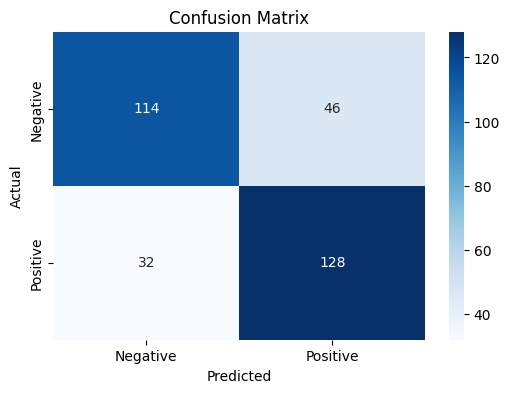


Example Predictions:
Review: The product is amazing and works perfectly!
Sentiment: 🟢 Positive

Review: Really disappointed, it stopped working after a week.
Sentiment: 🔴 Negative

Review: Great device for reading, love the screen quality!
Sentiment: 🟢 Positive



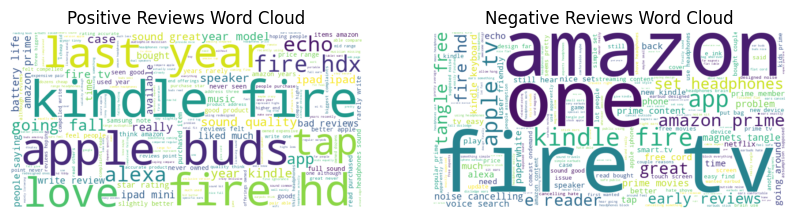


Model and TF-IDF vectorizer saved for future use.


In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Step 2: Download NLTK resources
nltk.download('stopwords')


# Step 4: Create sentiment labels based on reviews.rating
# Assume ratings 4-5 are Positive (1), 1-3 are Negative (0)
df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

# View sentiment distribution
print("Sentiment distribution:")
print(df['sentiment'].value_counts(normalize=True).rename("proportion"))

# Step 5: Text Preprocessing using RegexpTokenizer
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['reviews.text'].apply(preprocess_text)

# Step 6: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['sentiment']

# Step 7: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 9: Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 10: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 11: Prediction Function
def predict_sentiment(review_text):
    cleaned_review = preprocess_text(review_text)
    review_tfidf = tfidf.transform([cleaned_review]).toarray()
    prediction = model.predict(review_tfidf)[0]
    return "🟢 Positive" if prediction == 1 else "🔴 Negative"

# Step 12: Example Predictions
example_reviews = [
    "The product is amazing and works perfectly!",
    "Really disappointed, it stopped working after a week.",
    "Great device for reading, love the screen quality!"
]
print("\nExample Predictions:")
for review in example_reviews:
    print(f"Review: {review}")
    print(f"Sentiment: {predict_sentiment(review)}\n")

# Step 13: Word Cloud Visualization
positive_text = ' '.join(df[df['sentiment'] == 1]['cleaned_text'])
negative_text = ' '.join(df[df['sentiment'] == 0]['cleaned_text'])

if positive_text:
    plt.figure(figsize=(10, 5))
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Positive Reviews Word Cloud')
    plt.axis('off')

if negative_text:
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Negative Reviews Word Cloud')
    plt.axis('off')

plt.show()

# Step 14: Save model and vectorizer
import joblib
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("\nModel and TF-IDF vectorizer saved for future use.")


SyntaxError: invalid decimal literal (ipython-input-58-958798671.py, line 5)

In [ ]:
# Step 1: Write the Streamlit app to a file
app_code = '''
import streamlit as st
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')

model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\\w+')

def preprocess_text(text):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def predict_sentiment(text):
    cleaned = preprocess_text(text)
    features = vectorizer.transform([cleaned])
    pred = model.predict(features)[0]
    return "🟢 Positive" if pred == 1 else "🔴 Negative"

st.title("Customer Review Sentiment Analysis")

user_input = st.text_area("Enter your review here:")

if st.button("Predict Sentiment"):
    if not user_input.strip():
        st.warning("Please enter some text.")
    else:
        result = predict_sentiment(user_input)
        st.success(f"Sentiment: {result}")
'''

with open('app.py', 'w') as f:
    f.write(app_code)

# Step 2: Install streamlit and pyngrok silently
!pip install -q streamlit pyngrok

# Step 3: Setup and start ngrok tunnel
from pyngrok import ngrok

ngrok.kill()  # Kill any previous tunnels

public_url = ngrok.connect(port=8501)
print(f"Open this URL to access your Streamlit app:\n{public_url}")

# Step 4: Run Streamlit app in background
get_ipython().system_raw('streamlit run app.py &')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


ERROR:pyngrok.process.ngrok:t=2025-07-22T11:31:00+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-22T11:31:00+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-22T11:31:00+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.